# Electron Time of Flight (ToF) Algorithm

Released under a Creative Commons license by Luke Hasler.


Firstly let's install kneed onto our system to ensure we have all the necessary programs. The same code can be used to install any Python module by replacing 'kneed' with 'numpy' etc.

In [5]:
import sys
!{sys.executable} -m pip install kneed    # Installs kneed if you don't already have it installed.

  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.4.1
    Uninstalling widgetsnbextension-3.4.1:
      Successfully uninstalled widgetsnbextension-3.4.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.15.1
    Uninstalling numpy-1.15.1:
      Successfully uninstalled numpy-1.15.1


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\bluse\\anaconda3\\lib\\site-packages\\~umpy\\core\\multiarray.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

ERROR: Invalid requirement: '#'


Let's import all of the necessary modules for using the code:

In [138]:
import pandas as pd                         # Imports modules which will be used throughout the code.
import numpy as np                          
import matplotlib                           
from matplotlib import pyplot as plt        
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats, integrate                     
from kneed import KneeLocator               
import math
from sympy.solvers import solve
from sympy import Symbol
import os
import ipywidgets as widgets

In [325]:
widget_width = '900px'
padding = '0px 0px 0px 4px'

In [326]:
text0 = widgets.Text(
    value="",
    description="File Path or URL:",
    placeholder="Enter file path or URL to file adding '?raw=true' to the end of any URL",
    style={"description_width": "initial"},
    layout=widgets.Layout(width=widget_width, padding=padding),
)
text0

text1 = widgets.Text(
    value="",
    description="Pad Voltage / V:",
    placeholder="Enter pad voltage",
    style={"description_width": "initial"},
    layout=widgets.Layout(width=widget_width, padding=padding),
)
text1

text2 = widgets.Text(
    value="",
    description="Resistance / $ \Omega $:",
    placeholder="Enter resistance",
    style={"description_width": "initial"},
    layout=widgets.Layout(width=widget_width, padding=padding),
)
text2

text3 = widgets.Text(
    value="",
    description="Thickness / $\mu$m:",
    placeholder="Enter thickness",
    style={"description_width": "initial"},
    layout=widgets.Layout(width=widget_width, padding=padding),
)
text3

text4 = widgets.Text(
    value="",
    description="Filepath to save the data:",
    placeholder="Where do you want to save the data?",
    style={"description_width": "initial"},
    layout=widgets.Layout(width=widget_width, padding=padding),
)
text4

Text(value='', description='Filepath to save the data:', layout=Layout(padding='0px 0px 0px 4px', width='900px…

In [327]:
toolbar_widget = widgets.VBox()
toolbar_widget.children = [
    text0,
    text1,
    text2,
    text3,
    text4,
]
toolbar_widget

In [308]:
filename = text0.value
Pad_Voltage = float(text1.value)
Resistance = float(text2.value)
Thickness = float(text3.value) * 10 ** (-6)
savename = text4.value

Please now input your filename below. If you use a URL please type '?raw=true' after the URL or the data will be read incorrectly. You can also use a file path on your local desktop or via the cloud etc, in which case this should not be necessary.

This code will then read in the file to a pandas dataframe and assign each of the columns the names "Time" and "Voltage" whilst removing the automatically generated script at the top of each column. If you need to access these columns they are saved in the dataframe df and are left unchanged.

Make sure you type in the correct resistance in Ohms where prompted to do so. This allows the program to calculate the current using Ohm's law later on which will be important for finding the photocharge and the darkcurrent.

Finally, the code removes any 'Not a Number' values (NaN) and resets the index of the dataframe before printing out the first 10 rows so we can check it is formatting correctly.

In [309]:
df = pd.read_csv(filename, header=None, names=["Time", "Voltage"])     # Reads the data frame (df) ready for analysis and
                                            # assumes there are no headers in the data. If there are headers in the data 
                                            # delete "headers = None, names = ["Time", "Current"]".
df1 = df.drop(labels = [0,1,2,3,4,5,6,7,8], axis = 0)
df1.dropna()

df1.reset_index(drop = True, inplace = True)
print(df1.head(10))

              Time         Voltage
0  -7.90000000e-05  6.40312500e-01
1  -7.80000000e-05  6.40218750e-01
2  -7.70000000e-05  6.40625000e-01
3  -7.60000000e-05  6.40437500e-01
4  -7.50000000e-05  6.39437500e-01
5  -7.40000000e-05  6.39906250e-01
6  -7.30000000e-05  6.40312500e-01
7  -7.20000000e-05  6.39656250e-01
8  -7.10000000e-05  6.40218750e-01
9  -7.00000000e-05  6.40218750e-01


Let's look at the first and last 5 data points of our dataframe:

In [310]:
print(df1.head(5))
print(" ")
print(df1.tail(5))

              Time         Voltage
0  -7.90000000e-05  6.40312500e-01
1  -7.80000000e-05  6.40218750e-01
2  -7.70000000e-05  6.40625000e-01
3  -7.60000000e-05  6.40437500e-01
4  -7.50000000e-05  6.39437500e-01
 
               Time         Voltage
995  9.16000000e-04  6.54437500e-01
996  9.17000000e-04  6.53937500e-01
997  9.18000000e-04  6.54031250e-01
998  9.19000000e-04  6.53906250e-01
999  9.20000000e-04  6.54468750e-01


Since the data seems to have been cleaned and given column titles successfully, let's save our data to a new csv file which we can use for further analysis:

In [311]:
df1.to_csv("C:/Users/bluse/PycharmProjects/MSciProject/corrected_testdata.csv", index=False)

Now let's ensure that our data is of the correct type, correct it if it is not, and check the memory usage of the dataframe:

In [312]:
print("Information about the data:")                # Provides the number of data points, whether there are null data points,
                                                    # the data types, and the memory usage of the dataframe
print(" ")
print(df1.info())

df1["Time"] = df1["Time"].astype("float")           # Sets the data to datatype 'float64' if it isn't already in this form
df1["Voltage"] = df1["Voltage"].astype("float")
df1.reset_index(drop = True, inplace = True)        # Resets the index of the dataframe to avoid confusion

print(" ")
print("The datatypes of each column:")
print(df1.dtypes)                                   # Checks the new datatypes of the columns

Information about the data:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
Time       1000 non-null object
Voltage    1000 non-null object
dtypes: object(2)
memory usage: 15.7+ KB
None
 
The datatypes of each column:
Time       float64
Voltage    float64
dtype: object


The data tells us that we have two columns of 'float64' values with no null values (we eliminated those earlier) with information on the number of data values and the amount of memory used by the dataframe. This function can be used on a variety of classes in Python - not just dataframes.

Now we can do some quick and easy data analysis just to get an idea of trends within the data (which we will be able to see easily when we plot the data but this is easy analysis and doesnt take much time) but firstly, now that we have the voltage column exclusively in float form, we can add a new current column to our dataframe using Ohm's law. Notice that we have replaced all infinite data values with NaN values and then removed them to ensure any infinities in the data don't ruin our simulations later.

In [313]:
df1['Current'] = df1["Voltage"] / Resistance
df1.replace([np.inf, -np.inf], np.NaN, inplace=True)
df1.dropna()
print("A quick statistical description of the data set:")
print(" ")
print(df1.describe(include = "all"))

A quick statistical description of the data set:
 
              Time     Voltage     Current
count  1000.000000  998.000000  998.000000
mean      0.000421    0.770120    0.000770
std       0.000289    0.215325    0.000215
min      -0.000079    0.639437    0.000639
25%       0.000171    0.657375    0.000657
50%       0.000420    0.675000    0.000675
75%       0.000670    0.757344    0.000757
max       0.000920    1.999937    0.002000


Let us now plot the data using a line graph in Matplotlib:

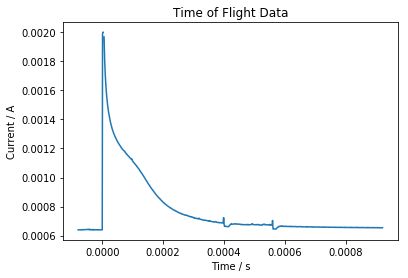

In [314]:
plt.figure()
plt.plot(df1["Time"], df1["Current"])
plt.title("Time of Flight Data")
plt.xlabel("Time / s")
plt.ylabel("Current / A")
plt.show()

We notice the dark current can be found by taking a mean average current for all points where $t<0$ which will be useful for finding the photocharge and then producing our double logarithmic plot of current and time later but will not be helpful for generating our initial polynomial regression of the trend so I will now filter the data into two dataframes - one with values  $t<0$ and the other $t \geq 0$:

In [315]:
with open("C:/Users/bluse/PycharmProjects/MSciProject/corrected_testdata.csv", 'r') as f:
    with open("C:/Users/bluse/PycharmProjects/MSciProject/corrected_testdata_2.csv", 'w') as g:
        with open("C:/Users/bluse/PycharmProjects/MSciProject/correlated_testdata_negative.csv", 'w') as h:
            for row in f:
                if row[0] != '-':
                    g.write(row)
                else:
                    h.write(row)
                
# The above section reads the first corrected file and writes a new csv file containing no values where the first character
# is '-' thereby removing all negative values. This means we can still access the data with negative values whilst also
# having cleaned the initial data.

df2 = pd.read_csv("C:/Users/bluse/PycharmProjects/MSciProject/corrected_testdata_2.csv") # A new dataframe is created.
df_negative = pd.read_csv("C:/Users/bluse/PycharmProjects/MSciProject/correlated_testdata_negative.csv", header=None, names=["Time", "Voltage"])
df2['Current'] = df2["Voltage"] / Resistance
df_negative["Current"] = df_negative["Voltage"] / Resistance
df2.replace([np.inf, -np.inf], np.NaN, inplace=True)
df2.dropna(inplace = True)
df2.reset_index(drop = True, inplace = True)
print("Sample data from $t<0$")
print(" ")
print(df2.head(5))
print(" ")
print("Sample data from $t >= 0$")
print(" ")
print(df_negative.head(5))

Sample data from $t<0$
 
       Time   Voltage   Current
0  0.000000  0.639781  0.000640
1  0.000001  1.986563  0.001987
2  0.000002  1.999937  0.002000
3  0.000003  1.999937  0.002000
4  0.000006  1.967375  0.001967
 
Sample data from $t >= 0$
 
       Time   Voltage   Current
0 -0.000079  0.640312  0.000640
1 -0.000078  0.640219  0.000640
2 -0.000077  0.640625  0.000641
3 -0.000076  0.640437  0.000640
4 -0.000075  0.639437  0.000639


Now the algorithm finds the dark current by averaging the current values of datapoints with $t<0$ and subtracts the dark current from the positive t dataframe. It then creates new columns for the logarithm of the time and current values and removes the infinite values created by taking logarithms of negative values (some of the noise with low values of current will be lower than the dark current so appear as negative when the logarithm is applied to them). The new dataframe is then printed out.

In [316]:
dark_current = df_negative["Current"].mean()
print(dark_current)
df2['Current'] -= dark_current
df2['Log Time'] = np.log10(df2["Time"])
df2['Log Current'] = np.log10(df2["Current"])
df2.replace([np.inf, -np.inf], np.NaN, inplace=True)
df2.dropna(inplace = True)
print("DF2 Head")
print(df2.head(5))

0.0006408777689873417
DF2 Head
       Time   Voltage   Current  Log Time  Log Current
1  0.000001  1.986563  0.001346 -6.000000    -2.871057
2  0.000002  1.999937  0.001359 -5.698970    -2.866761
3  0.000003  1.999937  0.001359 -5.522879    -2.866761
4  0.000006  1.967375  0.001326 -5.221849    -2.877294
5  0.000007  1.877844  0.001237 -5.154902    -2.907642


C:\Users\bluse\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\bluse\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


Now let's create a polynomial regression for the data so that we can calculate the photocharge. We can choose the number of free parameters we wish to use and the number of points in the linspace used to find our polynomial. We then plot the graph of current against time with the graph of the polynomial regression included to allow comparison and fine tuning.

Next, the following integral is taken to calculate the photocharge:

###                             $Q_{PHOTO} = \int^{t_{max}}_{t_{min}} I(t) . dt$ 

The generated polynomial regression:
 
           20             19             18            17
5.386e+63 x  - 4.738e+61 x  + 1.813e+59 x  - 3.79e+56 x 
              16             15             14             13
 + 4.253e+53 x  - 1.315e+50 x  - 2.925e+47 x  + 3.855e+44 x 
              12             11             10            9
 - 3.971e+40 x  - 3.676e+38 x  + 4.907e+35 x  - 3.56e+32 x
              8             7             6             5             4
 + 1.719e+29 x - 5.858e+25 x + 1.435e+22 x - 2.533e+18 x + 3.192e+14 x
              3             2
 - 2.796e+10 x + 1.602e+06 x - 55.65 x + 0.001487


C:\Users\bluse\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


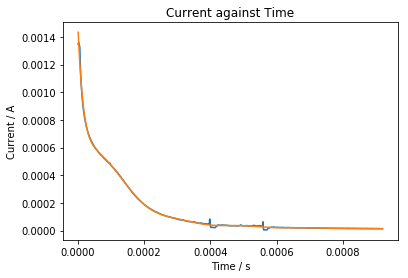

Photocharge: 1.3079055610332886e-07 with an error of: 1.065992798562846e-11


In [317]:
a = np.polyfit(df2["Time"], df2["Current"], 20) # You can change the number of free parameters here
b = np.poly1d(a)
print("The generated polynomial regression:")
print(" ")
print(b)                                        # We generate a polynomial expression for the data

myline = np.linspace(df2["Time"].min(), df2["Time"].max(), 1000)    # We can choose the number of linspace points here

plt.figure()
plt.plot(df2["Time"], df2["Current"])
plt.plot(myline, b(myline))
plt.title("Current against Time")
plt.xlabel("Time / s")
plt.ylabel("Current / A")
plt.show()

photocharge, photocharge_error = integrate.quad(b, df2["Time"].min(), df2["Time"].max()) 
print("Photocharge:", photocharge, "with an error of:", photocharge_error)

It is important to note that the error provided here does not take the fact we have converted from the raw data to a polynomial regression into account. 

Having found the photocharge it would now be wise to plot our double logarithmic plot.

Line plot of the data using matplotlib:


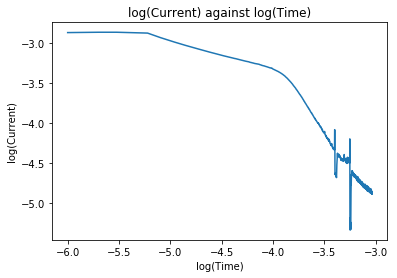

In [318]:
print("Line plot of the data using matplotlib:")
plt.figure()
plt.plot(df2["Log Time"], df2["Log Current"])
plt.title("log(Current) against log(Time)")
plt.xlabel("log(Time)")
plt.ylabel("log(Current)")
plt.show()

Let's create a polynomial regression of our double logarithmic plot so that we can apply a knee fitting algorithm to it later. We see in the results that if we try to take a regression across the entire dataset we see large differences in the lowest parts of the data so it will be wise instead to select an area of the data where the knee is likely to occur and then find a different regression curve using only that data to avoid compromising the algorithm (these strange curves at the beginning can confuse the knee finding algorithm).

The first graph should be used to visualise where the knee is on the t-axis so that the user can input correct outerbounds for the knee so that the bottom graph encompases the entire knee and can create a useful polynomial. Remember to check and change these values if you don't see a knee in the second graph.

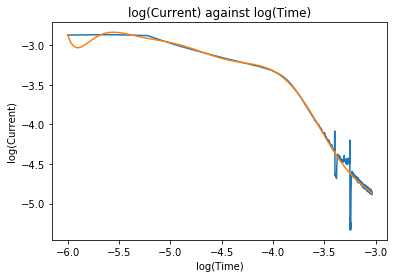

The polynomial for the double logarithmic plot:
 
        10         9         8        7        6             5
0.1291 x  + 5.586 x + 107.8 x + 1223 x + 9019 x + 4.517e+04 x
              4             3             2
 + 1.556e+05 x + 3.638e+05 x + 5.523e+05 x + 4.916e+05 x + 1.948e+05
 
--------------------------------------------------------------------------------------------------


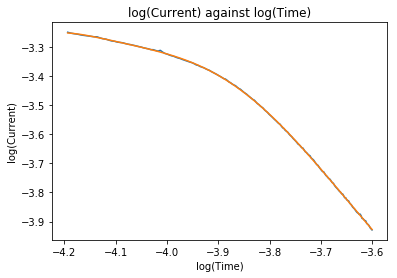

The zoomed-in polynomial for the double logarithmic plot:
 
        6        5             4             3             2
-78.32 x - 1815 x - 1.751e+04 x - 8.998e+04 x - 2.598e+05 x - 3.995e+05 x - 2.557e+05


In [319]:
f = np.polyfit(df2["Log Time"], df2["Log Current"], 10)         # We create a polynomial regression
p = np.poly1d(f)

myline_1 = np.linspace(df2["Log Time"].min(), df2["Log Time"].max(), 100)  # A linspace is created for the plot

plt.figure()
plt.plot(df2["Log Time"], df2["Log Current"])
plt.plot(myline_1, p(myline_1))
plt.title("log(Current) against log(Time)")
plt.xlabel("log(Time)")
plt.ylabel("log(Current)")
plt.show()

print("The polynomial for the double logarithmic plot:")
print(" ")
print(p)
print(" ")
print("--------------------------------------------------------------------------------------------------")
df3 = df2[df2["Log Time"] < -3.6]    # These values are where we zoom in along the t axis - change values as needed
df3 = df3[df3["Log Time"] > -4.2]

f1 = np.polyfit(df3["Log Time"], df3["Log Current"], 6)
p1 = np.poly1d(f1)

myline_2 = np.linspace(df3["Log Time"].min(), df3["Log Time"].max(), 100)

plt.figure()
plt.plot(df3["Log Time"], df3["Log Current"])
plt.plot(myline_2, p1(myline_2))
plt.title("log(Current) against log(Time)")
plt.xlabel("log(Time)")
plt.ylabel("log(Current)")
plt.show()

print("The zoomed-in polynomial for the double logarithmic plot:")
print(" ")
print(p1)

This section of code creates two linear regressions before and after the knee point (using user input numbers to indicate where to search) and then finds where the two lines intersect. You should select values close to where clear curvature appears but on as flat a section of the curve as physically possible. The values returned are the coordinates of the intersection.

In [323]:
df4 = df3[df3["Log Time"] < -3.8]
df5 = df3[df3["Log Time"] > -4.2]

v = np.array(df4["Log Time"].values.tolist())
w = df4["Log Current"].tolist()
x = v.reshape((-1, 1))
y = w

model = LinearRegression().fit(x, y)
intercept_1 = model.intercept_
slope_1 = model.coef_
#print('intercept:', intercept_1)
#print('slope:', slope_1)

v = np.array(df5["Log Time"].values.tolist())
w = df5["Log Current"].tolist()
x = v.reshape((-1, 1))
y = w

model = LinearRegression().fit(x, y)
intercept_2 = model.intercept_
slope_2 = model.coef_
#print('intercept:', intercept_2)
#print('slope:', slope_2)

x = Symbol('x')
m = solve(intercept_1 -intercept_2 + (slope_1 - slope_2) * x, x)
print("The Log(Time) value of the intersection:", m[x])
n = intercept_1 + slope_1 * m[x]
o = n[0]
print("The Log(Current) value of the intersection:", o)

The Log(Time) value of the intersection: -3.99771858510395
The Log(Current) value of the intersection: -3.34684845325681


Now we will attempt to find a more accurate representation of the knee point using the Kneed package for Python which is designed to search for knees. It can print out the values of the coordinate of the knee and can also print a visual representation of the knee and the knee point.

 
Log(Time) value of knee point
-4.173925197299174
 
Log(Current) value of knee point
-3.2574243207570404
None
 
Log(Time) value of knee point
-3.600326278518962
 
Log(Current) value of knee point
-3.928818835605298
None
 
Log(Time) value of knee point
-3.8820859364216496
 
Log(Current) value of knee point
-3.4176861601299606
None


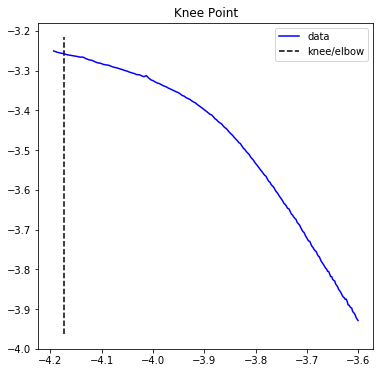

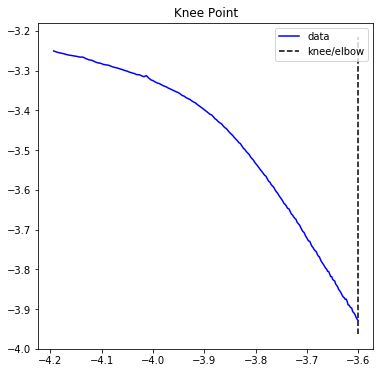

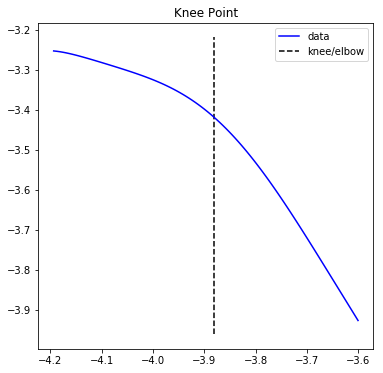

In [324]:
#kneedle = KneeLocator(myline, b(myline), S=1.0, curve = "convex", direction = "decreasing")
#print("Knee of the curve")

#print(kneedle.knee)
#print(" ")
#print("Elbow of the curve")

#print(kneedle.elbow)
#print(" ")
#print("Current value of knee point")

#print(kneedle.knee_y)
#print(kneedle.plot_knee())

kneedle_2 = KneeLocator(df5['Log Time'], df5['Log Current'], S=1.0, curve = "concave", direction = "decreasing", online = True)
knee_x = kneedle_2.knee
knee_y = kneedle_2.knee_y
print(" ")
print("Log(Time) value of knee point")
print(knee_x)
print(" ")
#print("Elbow of the curve")

#print(kneedle_2.elbow)
#print(" ")
print("Log(Current) value of knee point")
print(knee_y)
print(kneedle_2.plot_knee())

kneedle_2 = KneeLocator(df5['Log Time'], df5['Log Current'], S=1.0, curve = "concave", direction = "decreasing", online = True, interp_method = 'polynomial')
knee_x = kneedle_2.knee
knee_y = kneedle_2.knee_y
print(" ")
print("Log(Time) value of knee point")
print(knee_x)
print(" ")
#print("Elbow of the curve")

#print(kneedle_2.elbow)
#print(" ")
print("Log(Current) value of knee point")
print(knee_y)
print(kneedle_2.plot_knee())

kneedle_2 = KneeLocator(myline_2, p1(myline_2), S=1.0, curve = "concave", direction = "decreasing")
knee_x = kneedle_2.knee
knee_y = kneedle_2.knee_y
print(" ")
print("Log(Time) value of knee point")
print(knee_x)
print(" ")
#print("Elbow of the curve")

#print(kneedle_2.elbow)
#print(" ")
print("Log(Current) value of knee point")
print(knee_y)
print(kneedle_2.plot_knee())

Finally, this code takes all of the main results from this process and saves them into a csv file. If the file already exists it will append data into the existing table - if the file does not yet exist it will instead create it wherever the filepath has specified.

In [322]:
data = {'Pad Voltage/V': [Pad_Voltage], 'Resistance/Ohms': [Resistance], 'Thickness/m': [Thickness], 'Time [Fit]/s': [math.e**(m[x])], 'Time [Knee]/s': [math.e**(knee_x)], 'Dark current/A': [dark_current], 'Photocharge/C': [photocharge], 'Photocharge error/C': [photocharge_error], 'Alpha1': [slope_1[0] + 1], 'Alpha2': [1 - slope_2[0]], 'Energy/J': [Pad_Voltage / Thickness], 'Mobility [Fit]': [(Thickness)**2 / (math.e**(o) * Resistance)], 'Mobility [Knee]': [(Thickness)**2 / (math.e**(knee_y) * Resistance)], 'sqrt(Energy)/J': [math.sqrt(Pad_Voltage / Thickness)], 'Log(Time) [Int]': [m[x]], 'Log(Current) [Int]': [o], 'Log(Time) [Knee]': [knee_x], 'Log(Current) [Knee]': [knee_y]}  
main_dataframe = pd.DataFrame(data)
    
if os.path.isfile(savename) == True:
    main_dataframe.to_csv(savename, mode = 'a', header = False, index = False)
else:
    main_dataframe.to_csv(savename, header = True, index = False)